[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 concepts.

* Using [chat messages](https://docs.langchain.com/oss/python/langchain/messages) as our graph state
* Using [chat models](https://docs.langchain.com/oss/python/integrations/chat) in graph nodes
* [Binding tools](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to our chat model
* [Executing tool calls](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [messages](https://docs.langchain.com/oss/python/langchain/messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="LLM")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Paddy"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="LLM"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Paddy"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: LLM

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Paddy

Yes, that's right.
================================== Ai Message ==================================
Name: LLM

Great, what would you like to learn about.
================================ Human Message =================================
Name: Paddy

I want to learn about the best place to see Orcas in the US.


## Chat Models

Chat models use a sequence of messages as input and support message types, as discussed above.

There are [many](https://docs.langchain.com/oss/python/integrations/chat) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [26]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="moonshotai/kimi-k2-instruct-0905", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [27]:
pprint(result.content)

('Best U.S. spots to reliably see wild orcas (killer whales) without having to '
 'charter a plane to Alaska:\n'
 '\n'
 '1. Salish Sea – Washington State  \n'
 '   • Season: Mid-May → early October (peak late July-Sept)  \n'
 '   • Where to launch: Friday Harbor or Roche Harbor (San Juan Island), '
 'Anacortes, or Bellingham.  \n'
 '   • Why it’s #1: Two “resident” fish-eating pods (J & L pods) plus '
 'transient mammal-hunting orcas use these waters every summer; land-based '
 'lookout at Lime Kiln Point State Park (“Whale Watch Park”).  \n'
 '   • Viewing style: Half-day to full-day boat tours (zodiacs or larger '
 'catamarans) or shore-based watching from the west-side cliffs.  \n'
 '   • Success rate: 90 %+ in peak months with a good operator.\n'
 '\n'
 '2. Inside Passage & Kenai Fjords – Alaska  \n'
 '   • Season: Mid-May → mid-Sept (some operators run April-Sept)  \n'
 '   • Hot ports: Seward (Kenai Fjords NP), Juneau, Gustavus (Glacier Bay NP), '
 'Ketchikan.  \n'
 '   • What yo

In [28]:
result.response_metadata

{'token_usage': {'completion_tokens': 927,
  'prompt_tokens': 82,
  'total_tokens': 1009,
  'completion_time': 4.201986877,
  'completion_tokens_details': None,
  'prompt_time': 0.013350873,
  'prompt_tokens_details': None,
  'queue_time': 0.266497814,
  'total_time': 4.21533775},
 'model_name': 'moonshotai/kimi-k2-instruct-0905',
 'system_fingerprint': 'fp_241bc7119c',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://docs.langchain.com/oss/python/integrations/chat) and [tool calling interface](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [29]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [30]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Multiply 2 by 56", name="Paddy")])

In [31]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 56},
  'id': 'functions.multiply:0',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use  [messages](https://docs.langchain.com/oss/python/langchain/overview#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [32]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will overwrite the prior `messages` value!
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers) to address this.

Reducers specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [35]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built  [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [36]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [37]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='0772aecf-d786-4f09-9735-9555412783ef'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='bf3f973f-7364-473b-8424-f179ffb459cc'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='23398eae-dad3-458e-bcaf-21ccda5019da')]

## Our graph

Now, lets use `MessagesState` with a graph.

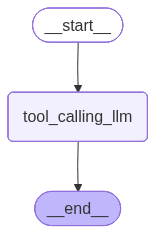

In [38]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [39]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [40]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (functions.multiply:0)
 Call ID: functions.multiply:0
  Args:
    a: 2
    b: 3
